In [1]:
import io
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from pathlib import Path
from PIL import Image 

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
path = Path("analyze.ipynb")
project_path = str(path.parent.absolute().parent)

In [3]:
def read_csv(path: str) -> pd.DataFrame:
    return pd.read_csv(os.path.join(project_path, path))

def read_image(image_name: str) -> Image:
    with h5py.File(os.path.join(project_path, r"data\raw", "train-image.hdf5"), "r") as f:
        im = Image.open(io.BytesIO(f[image_name][()]))
    return im

def load_hdf5(path: str):
    with h5py.File(os.path.join(project_path, path), "r") as f:
        file = f
    return file

In [4]:
train_hdf5 = load_hdf5(r"data\raw\train-image.hdf5")
train_hdf5

<Closed HDF5 file>

In [5]:
with h5py.File(os.path.join(project_path, r"data\raw\train-image.hdf5"), "r") as f:
    keys = list(f.keys())[:10]
    labels = [1] * 10
    data = []
    for i in keys:
        im = Image.open(io.BytesIO(f[i][()]))
        im = im.resize((128, 128))
        pix = np.array(im)
        data.append(pix)
        print(pix.shape)
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))

dataset


(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


<_TensorSliceDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [6]:
next(iter(dataset))

(<tf.Tensor: shape=(128, 128, 3), dtype=uint8, numpy=
 array([[[180, 146, 134],
         [180, 146, 134],
         [180, 146, 134],
         ...,
         [192, 154, 145],
         [190, 152, 143],
         [189, 152, 143]],
 
        [[185, 151, 139],
         [184, 150, 138],
         [184, 149, 137],
         ...,
         [189, 150, 142],
         [188, 150, 141],
         [186, 149, 140]],
 
        [[192, 156, 144],
         [191, 155, 143],
         [190, 154, 142],
         ...,
         [183, 145, 136],
         [182, 144, 135],
         [183, 145, 136]],
 
        ...,
 
        [[191, 150, 144],
         [184, 143, 137],
         [178, 137, 131],
         ...,
         [176, 133, 120],
         [175, 131, 119],
         [175, 132, 119]],
 
        [[190, 149, 143],
         [184, 143, 137],
         [178, 138, 130],
         ...,
         [174, 130, 117],
         [175, 131, 118],
         [176, 132, 119]],
 
        [[188, 147, 141],
         [183, 142, 136],
         [177,

In [7]:
im = read_image("ISIC_0015670")
pix = np.array(im)
pix.shape

(139, 139, 3)

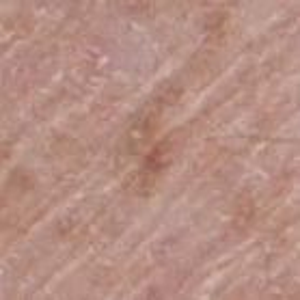

In [8]:
im = read_image("ISIC_0015670")
im.resize((300, 300))

In [16]:
dataset = tf.data.Dataset.range(10)
list(dataset)

[<tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=2>,
 <tf.Tensor: shape=(), dtype=int64, numpy=3>,
 <tf.Tensor: shape=(), dtype=int64, numpy=4>,
 <tf.Tensor: shape=(), dtype=int64, numpy=5>,
 <tf.Tensor: shape=(), dtype=int64, numpy=6>,
 <tf.Tensor: shape=(), dtype=int64, numpy=7>,
 <tf.Tensor: shape=(), dtype=int64, numpy=8>,
 <tf.Tensor: shape=(), dtype=int64, numpy=9>]

In [27]:
split = 8
dataset_train = dataset.window(split, split+10).flat_map(lambda ds: ds)
# [0, 1, 2, 4, 5, 6, 8, 9]
dataset_validation = dataset.skip(split).window(1, split + 10).flat_map(lambda ds: ds)
# [3, 7]

In [28]:
list(dataset_train)

[<tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=2>,
 <tf.Tensor: shape=(), dtype=int64, numpy=3>,
 <tf.Tensor: shape=(), dtype=int64, numpy=4>,
 <tf.Tensor: shape=(), dtype=int64, numpy=5>,
 <tf.Tensor: shape=(), dtype=int64, numpy=6>,
 <tf.Tensor: shape=(), dtype=int64, numpy=7>,
 <tf.Tensor: shape=(), dtype=int64, numpy=9>]

In [19]:
list(dataset_validation)

[<tf.Tensor: shape=(), dtype=int64, numpy=8>]

In [20]:
list(dataset.skip(8))

[<tf.Tensor: shape=(), dtype=int64, numpy=8>,
 <tf.Tensor: shape=(), dtype=int64, numpy=9>]

In [23]:
dataset.skip(8)

<_SkipDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>

In [24]:
dataset

AttributeError: '_RangeDataset' object has no attribute 'shape'